In [1]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings(action='ignore') # Ignore warning message

# date path
data_path = '../Data/'

sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')



Data Downcasting


In [2]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    df = downcast(df)

54.2% compressed
38.5% compressed
54.2% compressed
39.8% compressed
70.8% compressed


### Feature Engineering I - handling sales_train, shops, items, item_categories

In [3]:
# Extract data with a item_price greater than 0
sales_train = sales_train[sales_train['item_price'] > 0]
# Extract data with a item_priceof less than 50,000
sales_train = sales_train[sales_train['item_price'] < 50000]
# Extract data with item_cnt_day greater than 0
sales_train = sales_train[sales_train['item_cnt_day'] > 0]
# Extract data with item_cnt_day less than 1,000
sales_train = sales_train[sales_train['item_cnt_day'] < 1000]

In [4]:
#  Modify shop_id in sales_train data
sales_train.loc[sales_train['shop_id'] == 0, 'shop_id'] = 57
sales_train.loc[sales_train['shop_id'] == 1, 'shop_id'] = 58
sales_train.loc[sales_train['shop_id'] == 10, 'shop_id'] = 11
sales_train.loc[sales_train['shop_id'] == 39, 'shop_id'] = 40

#  Modify shop_id in test data
test.loc[test['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 39, 'shop_id'] = 40

In [5]:
# Leaking to imporve performance
unique_test_shop_id = test['shop_id'].unique()
unique_test_item_id = test['item_id'].unique()
sales_train = sales_train[sales_train['shop_id'].isin(unique_test_shop_id)]
sales_train = sales_train[sales_train['item_id'].isin(unique_test_item_id)]

Shops: create derived features and encode

In [6]:
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0])
shops['city'].unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [7]:
shops.loc[shops['city'] =='!Якутск', 'city'] = 'Якутск'

In [8]:
from sklearn.preprocessing import LabelEncoder

# Create Label Encoder
label_encoder = LabelEncoder()
# City Feature Label Encoding 
shops['city'] = label_encoder.fit_transform(shops['city'])

In [9]:
# Remove shop_name feature
shops = shops.drop('shop_name', axis=1)

shops.head()

,shop_id,city
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


itmes: Create derived features

In [10]:
# Remove item_name feature
items = items.drop(['item_name'], axis=1)

In [11]:
# Create the date the product was first sold as a feature
items['first_sale_date'] = sales_train.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']

items.head()

,item_id,item_category_id,first_sale_date
0,0,40,NaN
1,1,76,NaN
2,2,40,NaN
3,3,40,NaN
4,4,40,NaN


In [12]:
items[items['first_sale_date'].isna()]

,item_id,item_category_id,first_sale_date
0,0,40,NaN
1,1,76,NaN
2,2,40,NaN
3,3,40,NaN
4,4,40,NaN
...,...,...,...
22160,22160,40,NaN
22161,22161,37,NaN
22165,22165,31,NaN
22168,22168,62,NaN


In [13]:
# Replace NaN of first_sale_date with 34
items['first_sale_date'] = items['first_sale_date'].fillna(34)

Create item_categories derived feature and encode

In [14]:
# Extract the first word of the item_categories_name into category
item_categories['category'] = item_categories['item_category_name'].apply(lambda x: x.split()[0])  

In [15]:
item_categories['category'].value_counts()

category
Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Служебные      2
Чистые         2
PC             1
Билеты         1
Доставка       1
Элементы       1
Name: count, dtype: int64

In [16]:
def make_etc(x):
    if len(item_categories[item_categories['category']==x]) >= 5:
        return x
    else:
        return 'etc'

# Replace with 'etc' if category count is less than 5
item_categories['category'] = item_categories['category'].apply(make_etc)

In [17]:
item_categories.head()

,item_category_name,item_category_id,category
0,PC - Гарнитуры/Наушники,0,etc
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары


In [18]:
# Create Label Encoder
label_encoder = LabelEncoder()
# Category Feature Label Encoding 
item_categories['category'] = label_encoder.fit_transform(item_categories['category'])

# Remove item_category_name feature
item_categories = item_categories.drop('item_category_name', axis=1)

In [19]:
from itertools import product

train = []
# Create date_block_num, sop_id, item_id combination
for i in sales_train['date_block_num'].unique():
    all_shop = sales_train.loc[sales_train['date_block_num']==i, 'shop_id'].unique()
    all_item = sales_train.loc[sales_train['date_block_num']==i, 'item_id'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['date_block_num', 'shop_id', 'item_id'] # base features
train = pd.DataFrame(np.vstack(train), columns=idx_features)

In [20]:
train.head()

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2574
2,0,59,2607
3,0,59,2614
4,0,59,2808


In [21]:
from itertools import product

train = []
# Create date_block_num, sop_id, item_id combination
for i in sales_train['date_block_num'].unique():
    all_shop = sales_train.loc[sales_train['date_block_num']==i, 'shop_id'].unique()
    all_item = sales_train.loc[sales_train['date_block_num']==i, 'item_id'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['date_block_num', 'shop_id', 'item_id'] # base features
train = pd.DataFrame(np.vstack(train), columns=idx_features)

In [22]:
group = sales_train.groupby(idx_features, as_index=False).agg({'item_cnt_day': 'sum',
                                               'item_price': 'mean'})

group = group.rename(columns={'item_cnt_day': 'item_cnt_month', 'item_price': 'item_price_mean'})
group.head()
train = train.merge(group, on=idx_features, how='left')

In [23]:
train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean
0,0,59,22154,1.0,999.0
1,0,59,2574,2.0,399.0
2,0,59,2607,NaN,NaN
3,0,59,2614,NaN,NaN
4,0,59,2808,15.0,999.0


In [24]:
import gc

# group variable garbage collection
del group
gc.collect()

0

In [25]:
# Add a feature for the number of items sold
group = sales_train.groupby(idx_features).agg({'item_cnt_day': 'count'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_count'})

train = train.merge(group, on=idx_features, how='left')

In [26]:
# Garbage collection
del group, sales_train
gc.collect()
train.head()


,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count
0,0,59,22154,1.0,999.0,1.0
1,0,59,2574,2.0,399.0,2.0
2,0,59,2607,NaN,NaN,NaN
3,0,59,2614,NaN,NaN,NaN
4,0,59,2808,15.0,999.0,9.0


Concatenate test data, Merge remaining data

In [31]:
display(test.head())
print()
# Set test data date_block_num to 34
test['date_block_num'] = 34

# Concatenate train and test
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)
# Replace NaN with 0
all_data = all_data.fillna(0)

display(all_data.head())
display(all_data.tail())

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count
0,0,59,22154,1.0,999.0,1.0
1,0,59,2574,2.0,399.0,2.0
2,0,59,2607,0.0,0.0,0.0
3,0,59,2614,0.0,0.0,0.0
4,0,59,2808,15.0,999.0,9.0


,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count
2952842,34,45,18454,0.0,0.0,0.0
2952843,34,45,16188,0.0,0.0,0.0
2952844,34,45,15757,0.0,0.0,0.0
2952845,34,45,19648,0.0,0.0,0.0
2952846,34,45,969,0.0,0.0,0.0


In [32]:
# Merge other data
all_data = all_data.merge(shops, on='shop_id', how='left')
all_data = all_data.merge(items, on='item_id', how='left')
all_data = all_data.merge(item_categories, on='item_category_id', how='left')

# Data downcasting
all_data = downcast(all_data)

# Garbage collection
del shops, items, item_categories
gc.collect();

68.9% compressed


Feature summary

In [34]:
def resumetable(df):
    print(f'Data Shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['Dtypes'])
    summary['Null'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First_values'] = df.loc[0].values
    summary['Second_values'] = df.loc[1].values
    summary['Third_values'] = df.loc[2].values
    
    return summary

In [35]:
resumetable(all_data)

Data Shape: (2952847, 10)


,Dtypes,Null,Uniques,First_values,Second_values,Third_values
date_block_num,int8,0,35,0.0,0.0,0.0
shop_id,int8,0,42,59.0,59.0,59.0
item_id,int16,0,5100,22154.0,2574.0,2607.0
item_cnt_month,int16,0,383,1.0,2.0,0.0
item_price_mean,float64,0,23262,999.0,399.0,0.0
item_count,int8,0,40,1.0,2.0,0.0
city,int8,0,28,30.0,30.0,30.0
item_category_id,int8,0,62,37.0,55.0,55.0
first_sale_date,int8,0,35,0.0,0.0,0.0
category,int8,0,10,5.0,7.0,7.0


In [37]:
all_data.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2952847.0,21.943367,9.438631,0.0,15.0,24.0,30.0,34.0
shop_id,2952847.0,31.332922,17.822284,2.0,16.0,34.0,47.0,59.0
item_id,2952847.0,10836.313386,6233.255724,30.0,5128.0,10911.0,16057.0,22167.0
item_cnt_month,2952847.0,0.550419,5.011590,0.0,0.0,0.0,0.0,1305.0
item_price_mean,2952847.0,185.656114,794.959022,0.0,0.0,0.0,0.0,42990.0
item_count,2952847.0,0.415856,1.333602,0.0,0.0,0.0,0.0,57.0
city,2952847.0,15.334964,8.310242,0.0,10.0,15.0,22.0,30.0
item_category_id,2952847.0,46.228789,16.200762,0.0,37.0,47.0,57.0,83.0
first_sale_date,2952847.0,9.908104,10.319897,0.0,0.0,7.0,19.0,34.0
category,2952847.0,5.712392,1.956827,0.0,5.0,6.0,7.0,9.0


Visualization

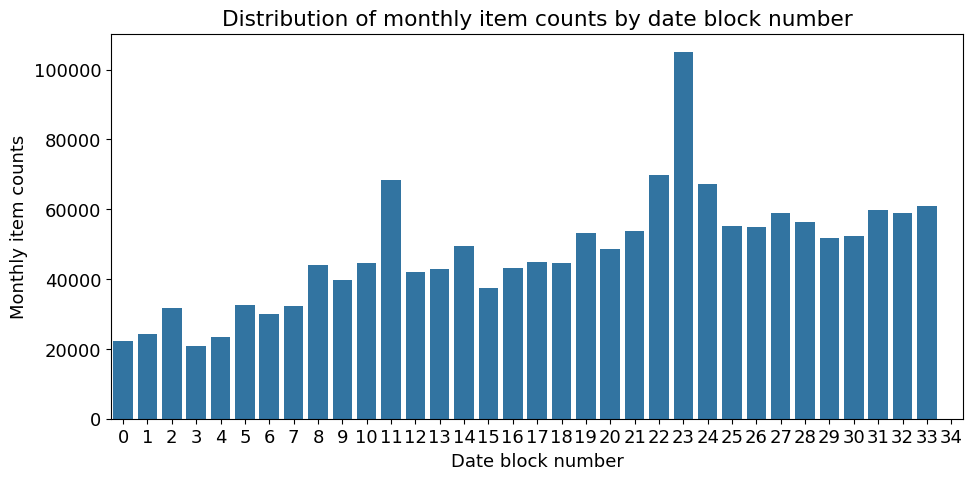

In [41]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=13)
figure, ax = plt.subplots() 
figure.set_size_inches(11, 5)

# total montly item sales
group_month_sum = all_data.groupby('date_block_num',as_index=False).agg({'item_cnt_month': 'sum'})
# group_month_sum = group_month_sum.reset_index()

sns.barplot(x='date_block_num', y='item_cnt_month', data=group_month_sum)
ax.set(title='Distribution of monthly item counts by date block number',
       xlabel='Date block number', 
       ylabel='Monthly item counts');

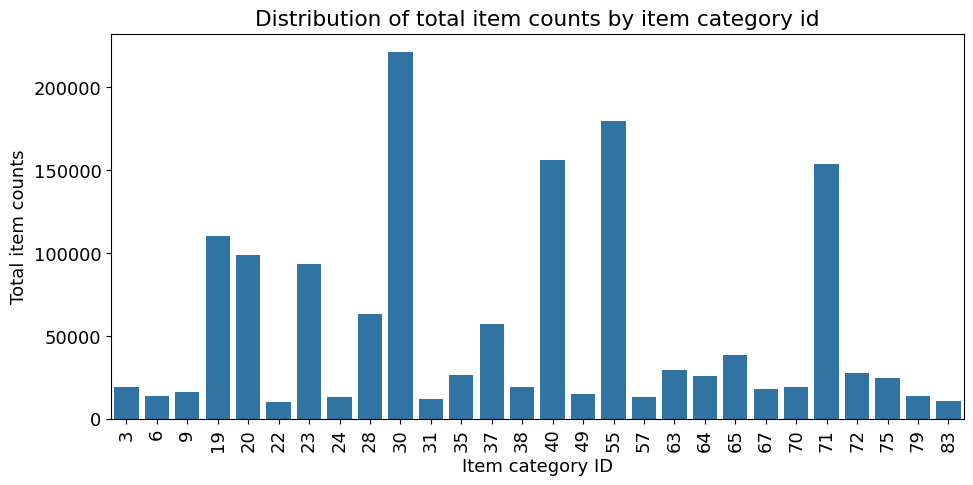

In [47]:
figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# Total item sales by item_category_id
group_cat_sum = all_data.groupby('item_category_id').agg({'item_cnt_month': 'sum'})
group_cat_sum = group_cat_sum.reset_index()

# Extract only item categories with total sales > 10,000
group_cat_sum = group_cat_sum[group_cat_sum['item_cnt_month'] > 10000]

sns.barplot(x='item_category_id', y='item_cnt_month', data=group_cat_sum)
ax.set(title='Distribution of total item counts by item category id',
       xlabel='Item category ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90) # Rotate X label

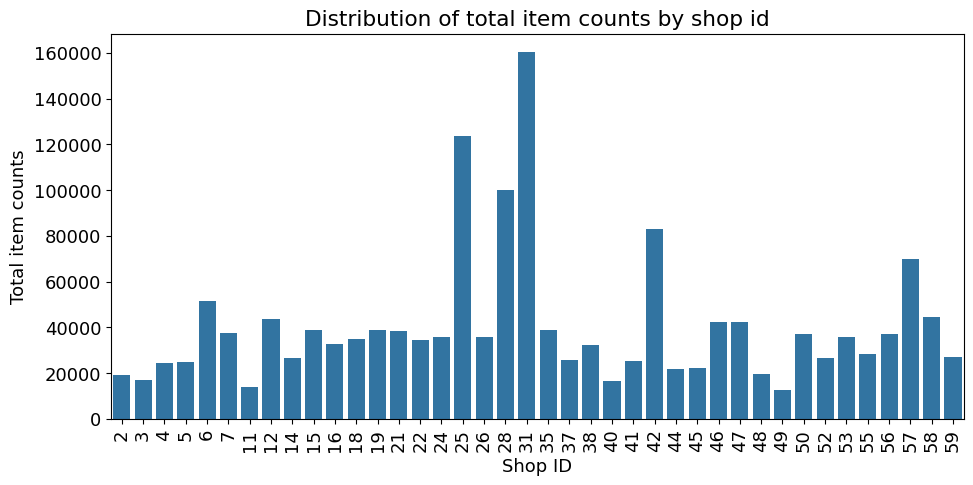

In [48]:
figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# Total item sales by shop_id
group_shop_sum = all_data.groupby('shop_id').agg({'item_cnt_month': 'sum'})
group_shop_sum = group_shop_sum.reset_index()

group_shop_sum = group_shop_sum[group_shop_sum['item_cnt_month'] > 10000]

sns.barplot(x='shop_id', y='item_cnt_month', data=group_shop_sum)
ax.set(title='Distribution of total item counts by shop id',
       xlabel='Shop ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90)

In [49]:
def add_mean_features(df, mean_features, idx_features):
    # Check base features
    assert (idx_features[0] == 'date_block_num') and \
           len(idx_features) in [2, 3]
    #The first element in idx_features is 'date_block_num'.
    #The length of idx_features is either 2 or 3.
    #If these conditions are not met, an AssertionError will be raised.
    
    # Set derived feature name 
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '_mean_sales'
    else:
        feature_name = idx_features[1] + '_' + idx_features[2] + '_mean_sales'
    
    # Get average monthly sales by grouping based on base features
    group = df.groupby(idx_features).agg({'item_cnt_month': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'item_cnt_month': feature_name})
    
    # Merge df with group based on idx_features
    df = df.merge(group, on=idx_features, how='left')
    # Date downcasting
    df = downcast(df, False)
    # Append newly created mean_feature_name features to the mean_features list
    mean_features.append(feature_name)
    
    # Garbage collection
    del group
    gc.collect()
    
    return df, mean_features

In [50]:
# List of derived features containing 'item_id' in the grouping base features
item_mean_features = []


# Create monthly average sales derived features grouped by ['date_block_num', 'item_id']
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id'])

# Create monthly average sales derived features grouped by ['date_block_num', 'item_id', 'city']
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id', 'city'])

### Feature Engineering II - Create Lag features
Create Average Monthly Sales Derived Feature by Base Feature

In [51]:
item_mean_features

['item_id_mean_sales', 'item_id_city_mean_sales']

In [52]:
# List of derived features containing 'shop_id' in the grouping base features
shop_mean_features = []

# Create monthly average sales derived features grouped by ['date_block_num', 'shop_id', 'item_category_id']
all_data, shop_mean_features = add_mean_features(df=all_data, 
                                                 mean_features=shop_mean_features,
                                                 idx_features=['date_block_num', 'shop_id', 'item_category_id'])

In [53]:
shop_mean_features

['shop_id_item_category_id_mean_sales']

Create Lag Features

In [54]:
all_data.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000000,0.000000,0.000000,0.000000
shop_id,59.000000,59.000000,59.000000,59.000000,59.000000
item_id,22154.000000,2574.000000,2607.000000,2614.000000,2808.000000
item_cnt_month,1.000000,2.000000,0.000000,0.000000,15.000000
item_price_mean,999.000000,399.000000,0.000000,0.000000,999.000000
item_count,1.000000,2.000000,0.000000,0.000000,9.000000
city,30.000000,30.000000,30.000000,30.000000,30.000000
item_category_id,37.000000,55.000000,55.000000,55.000000,30.000000
first_sale_date,0.000000,0.000000,0.000000,0.000000,0.000000
category,5.000000,7.000000,7.000000,7.000000,3.000000


In [55]:
def add_lag_features(df, lag_features_to_clip, idx_features, 
                     lag_feature, nlags=3, clip=False):
    # Copy only the part of the DataFrame needed to create the lag features
    df_temp = df[idx_features + [lag_feature]].copy() 

    # Create lag features
    for i in range(1, nlags+1):
        # Lag featrue name
        lag_feature_name = lag_feature +'_lag' + str(i)
        # Set df_temp column name
        df_temp.columns = idx_features + [lag_feature_name]
        # Add 1 to date_block_num feature in df_temp
        df_temp['date_block_num'] += 1
        # Merge df with df_temp based on idx_feature
        df = df.merge(df_temp.drop_duplicates(), 
                      on=idx_features, 
                      how='left')
        # Replace NaN with 0
        df[lag_feature_name] = df[lag_feature_name].fillna(0)
        # Add lag features to lag_features_to_clip to clip between 0 and 20
        if clip: 
            lag_features_to_clip.append(lag_feature_name)
    
    # Date downcasting
    df = downcast(df, False)
    # Garbage collection
    del df_temp
    gc.collect()
    
    return df, lag_features_to_clip

In [56]:
lag_features_to_clip = [] # list of lag features to be clipped to between 0 to 20 
idx_features = ['date_block_num', 'shop_id', 'item_id'] # base features

# Create 3 month lag features of item_cnt_month based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_cnt_month', 
                                                  nlags=3,
                                                  clip=True)

In [58]:
lag_features_to_clip

['item_cnt_month_lag1', 'item_cnt_month_lag2', 'item_cnt_month_lag3']

In [57]:
all_data.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000000,0.000000,0.000000,0.000000
shop_id,59.000000,59.000000,59.000000,59.000000,59.000000
item_id,22154.000000,2574.000000,2607.000000,2614.000000,2808.000000
item_cnt_month,1.000000,2.000000,0.000000,0.000000,15.000000
item_price_mean,999.000000,399.000000,0.000000,0.000000,999.000000
item_count,1.000000,2.000000,0.000000,0.000000,9.000000
city,30.000000,30.000000,30.000000,30.000000,30.000000
item_category_id,37.000000,55.000000,55.000000,55.000000,30.000000
first_sale_date,0.000000,0.000000,0.000000,0.000000,0.000000
category,5.000000,7.000000,7.000000,7.000000,3.000000


In [59]:
# Create 3 month lag features of item_count feature based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_count', 
                                                  nlags=3)

# Create 3 month lag features of item_price_mean feature based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_price_mean', 
                                                  nlags=3)

In [60]:
all_data.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000000,0.000000,0.000000,0.000000
shop_id,59.000000,59.000000,59.000000,59.000000,59.000000
item_id,22154.000000,2574.000000,2607.000000,2614.000000,2808.000000
item_cnt_month,1.000000,2.000000,0.000000,0.000000,15.000000
item_price_mean,999.000000,399.000000,0.000000,0.000000,999.000000
item_count,1.000000,2.000000,0.000000,0.000000,9.000000
city,30.000000,30.000000,30.000000,30.000000,30.000000
item_category_id,37.000000,55.000000,55.000000,55.000000,30.000000
first_sale_date,0.000000,0.000000,0.000000,0.000000,0.000000
category,5.000000,7.000000,7.000000,7.000000,3.000000


In [61]:
# Create lag features by item_mean_features element based on dx_features
display(item_mean_features)

for item_mean_feature in item_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=idx_features, 
                                                      lag_feature=item_mean_feature, 
                                                      nlags=3)
# Remove features in item_mean_features
all_data = all_data.drop(item_mean_features, axis=1)

['item_id_mean_sales', 'item_id_city_mean_sales']

In [62]:
display(shop_mean_features)

# Create lag features by shop_mean_features element based on ['date_block_num', 'shop_id', 'item_category_id']
for shop_mean_feature in shop_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=['date_block_num', 'shop_id', 'item_category_id'], 
                                                      lag_feature=shop_mean_feature, 
                                                      nlags=3)
# Remove features in shop_mean_features
all_data = all_data.drop(shop_mean_features, axis=1)

['shop_id_item_category_id_mean_sales']

In [68]:
all_data[['date_block_num', 'first_sale_date']]

,date_block_num,first_sale_date
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2952842,34,23
2952843,34,32
2952844,34,0
2952845,34,23
